In [1]:
# Import modules
import pandas as pd
from pathlib import Path
from joblib import load
from typing import Optional, Literal, Dict, Any, List
import seaborn as sns
import json
from venv import logger
import numpy as np
from numpy.linalg import pinv
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import statsmodels.api as sm


# Define data path
data_path = '../../data/raw'
processed_path = '../../data'

In [2]:
# Load data
try:
    
    df_player_15          = pd.read_csv(f"{data_path}/players_15.csv")
    df_player_16          = pd.read_csv(f"{data_path}/players_16.csv")
    df_player_17          = pd.read_csv(f"{data_path}/players_17.csv")
    df_player_18          = pd.read_csv(f"{data_path}/players_18.csv")
    df_player_19          = pd.read_csv(f"{data_path}/players_19.csv")
    df_player_20          = pd.read_csv(f"{data_path}/players_20.csv")
    df_player_21          = pd.read_csv(f"{data_path}/players_21.csv")
    df_player_22          = pd.read_csv(f"{data_path}/players_22.csv")


    print("Files loaded successfully")

except FileNotFoundError as e:
    print(e)
    print(f"Error: One or more files at {data_path} were not found.")
    exit()

C:\Users\Rubén Soriano\AppData\Local\Temp\ipykernel_12300\2456074113.py:4: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_player_15          = pd.read_csv(f"{data_path}/players_15.csv")
C:\Users\Rubén Soriano\AppData\Local\Temp\ipykernel_12300\2456074113.py:5: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_player_16          = pd.read_csv(f"{data_path}/players_16.csv")
C:\Users\Rubén Soriano\AppData\Local\Temp\ipykernel_12300\2456074113.py:7: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_player_18          = pd.read_csv(f"{data_path}/players_18.csv")


Files loaded successfully


C:\Users\Rubén Soriano\AppData\Local\Temp\ipykernel_12300\2456074113.py:11: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_player_22          = pd.read_csv(f"{data_path}/players_22.csv")


# Data  Cleaning

In [3]:
def drop_innecesary_columns(df:  pd.DataFrame):
        
    df_to_drop = df.copy()
    
    df_to_drop = df_to_drop.drop(columns=["player_face_url","club_logo_url",
                                            "club_flag_url","nation_logo_url",
                                            "nation_flag_url", "international_reputation",
                                            "work_rate","body_type","real_face",
                                            "release_clause_eur","player_tags",
                                            "player_traits", "nationality_id",
                                            "nationality_name","nation_team_id",
                                            "nation_position","nation_jersey_number"])
    df_to_drop = df_to_drop.drop(columns=["ls","st","rs","lw","lf","cf","rf","rw","lam",
                                            "cam","ram","lm","lcm","cm","rcm","rm","lwb",
                                            "ldm","cdm","rdm","rwb","lb","lcb","cb","rcb","rb","gk"])
    
    df = df_to_drop.drop(columns=["player_url", "club_jersey_number", "club_loaned_from"])
    
    return df

In [ ]:

dfs = {
    2015: df_player_15,
    2016: df_player_16,
    2017: df_player_17,
    2018: df_player_18,
    2019: df_player_19,
    2020: df_player_20,
    2021: df_player_21,
    2022: df_player_22,
}

# List to store all dfs with 'year' column
df_list = []

for year, df in dfs.items():
    df_temp = df.copy()
    df_temp["year"] = year
    df_list.append(df_temp)

# Concat everything into a single DataFrame
df_players_all = pd.concat(df_list, ignore_index=True)

In [5]:
df_players_all = drop_innecesary_columns(df_players_all)

# Rename columns
df_players_all = df_players_all.rename(columns={
    "sofifa_id": "player_id",
    "value_eur": "market_value",
    "age": "player_age",
    "wage_eur": "gross_salary_per_year"
})


# Drop NaN values
df_players_all = df_players_all.dropna(subset=["market_value", "gross_salary_per_year", "club_contract_valid_until"])

# Preprocess

In [ ]:
def convert_contract_year_to_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the contract validity year into a standard expiration date.

    This function transforms the 'club_contract_valid_until' column, which typically 
    contains years (e.g., 2023, 2024), into a full datetime object set to 
    June 30th of that year (standard football season end date).

    Steps:
    1. Coerces the column to numeric to handle strings or floats.
    2. Casts to nullable integer ('Int64') to preserve NaNs without converting years to floats.
    3. Constructs the date string 'YYYY-06-30'.
    4. Converts to datetime objects.

    Args:
        df (pd.DataFrame): Input dataframe containing the 'club_contract_valid_until' column.

    Returns:
        pd.DataFrame: A copy of the dataframe with the new 'contract_expiration' column 
                      and the original 'club_contract_valid_until' cleaned.

    Raises:
        ValueError: If 'club_contract_valid_until' is missing from the dataframe.
    """
    
    # Create a copy to avoid SettingWithCopyWarning on the original dataframe
    df_out = df.copy()

    target_col = "club_contract_valid_until"

    if target_col not in df_out.columns:
        raise ValueError(f"Column '{target_col}' not found in dataframe.")

    # 1. Clean and convert to numeric (handles '2023', 2023.0, and non-numeric errors)
    df_out[target_col] = pd.to_numeric(df_out[target_col], errors="coerce")

    # 2. Construct the date string
    # We use the nullable integer type 'Int64' to handle NaNs correctly. 
    years_series = df_out[target_col].astype("Int64").astype(str)
    
    date_strings = years_series + "-06-30"

    # 3. Convert to actual datetime objects
    df_out["contract_expiration"] = pd.to_datetime(date_strings, errors="coerce")

    return df_out


def predict_next_year_value(df_all: pd.DataFrame) -> pd.DataFrame:
    """
    Predicts the future market value for each player based on their historical valuation trajectory.

    For each player and each year 't', this function trains a linear regression model 
    using historical data up to year 't' to forecast the market value for year 't+1'.
    
    Constraints:
    - Predictions are strictly non-negative.
    - If insufficient history exists (N=1), the current value is used as a naive forecast (Persistence Model).

    Args:
        df_all (pd.DataFrame): DataFrame containing 'player_id', 'year', and 'market_value'.

    Returns:
        pd.DataFrame: A copy of the original DataFrame with an appended 'future_market_value' column.
    """

    # Create a working copy to avoid side effects on the input dataframe
    df = df_all.copy()
    
    # Ensure correct data types for numerical stability
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype(int)
    df["market_value"] = pd.to_numeric(df["market_value"], errors="coerce")

    # Sort by player and year to ensure temporal order
    df = df.sort_values(by=["player_id", "year"])

    # Vectorized placeholder for results
    predictions = np.full(len(df), np.nan)

    # Group by player to process each trajectory independently
    
    grouped = df.groupby("player_id")

    for player_id, group in grouped:
        
        # Extract arrays for performance (faster than pandas series access)
        years = group["year"].values
        values = group["market_value"].values
        indices = group.index.values
        
        n_samples = len(years)
        
        # Expanding window loop: Predict t+1 using data [0...t]
        for i in range(n_samples):
            
            # Define historical window (current year 'i' included)
            X_hist = years[:i+1].reshape(-1, 1)
            y_hist = values[:i+1]
            
            year_next = years[i] + 1
            
            # Strategy 1: Naive Persistence (Insufficient data)
            if len(X_hist) < 2:
                pred = values[i]
            
            # Strategy 2: Linear Extrapolation (Trend following)
            else:
                # Here we keep LinearRegression for readability and explicit modeling.
                model = LinearRegression()
                model.fit(X_hist, y_hist)
                
                # Predict for X = year_next
                pred = model.predict(np.array([[year_next]]))[0]

            # Apply logical constraint: Value cannot be negative
            predictions[df.index.get_loc(indices[i])] = max(0.0, pred)

    # Assign the computed array to the dataframe
    df["future_market_value"] = predictions

    return df

In [7]:
# # ===============================
# # 3. Convert contract year to date
# # ===============================
print("\nPreprocess 3. Convert contract year to date ")
df_players_all = convert_contract_year_to_date(df_players_all)


Preprocess 3. Convert contract year to date 


In [8]:
# # ===============================
# # 4. Predict next year valuation
# # ===============================
print("\nPreprocess 4. Predict next year valuation")
df_final = predict_next_year_value(df_players_all)


Preprocess 4. Predict next year valuation


In [9]:


def stepwise_selection(X: pd.DataFrame, y: pd.Series, 
                       threshold_in: float = 0.01, 
                       threshold_out: float = 0.05, 
                       verbose: bool = False) -> List[str]:
    """
    Performs forward-backward stepwise feature selection based on p-values.

    This algorithm iteratively adds the most statistically significant feature 
    (lowest p-value < threshold_in) and removes the least significant one 
    (highest p-value > threshold_out) to build an optimal linear model.

    Args:
        X (pd.DataFrame): Feature matrix (pre-scaled or raw).
        y (pd.Series): Target variable.
        threshold_in (float): Significance level for entering the model.
        threshold_out (float): Significance level for removing from the model.
        verbose (bool): If True, prints logs of feature addition/removal.

    Returns:
        List[str]: List of selected feature names.
    """
    initial_features = X.columns.tolist()
    included = []
    
    while True:
        changed = False
        
        # --- Forward Step ---
        excluded = list(set(initial_features) - set(included))
        new_pvals = pd.Series(index=excluded, dtype='float64')
        
        for new_column in excluded:
            # Fit OLS with current features + new candidate
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pvals[new_column] = model.pvalues[new_column]
            
        if not new_pvals.empty:
            best_pval = new_pvals.min()
            if best_pval < threshold_in:
                best_feature = new_pvals.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add  {best_feature:30} (p-value: {best_pval:.4e})")

        # --- Backward Step ---
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            # Check p-values of all included features (excluding intercept 'const')
            pvalues = model.pvalues.drop('const', errors='ignore')
            
            if not pvalues.empty:
                worst_pval = pvalues.max()
                if worst_pval > threshold_out:
                    worst_feature = pvalues.idxmax()
                    included.remove(worst_feature)
                    changed = True
                    if verbose:
                        print(f"Drop {worst_feature:30} (p-value: {worst_pval:.4e})")
        
        if not changed:
            break
            
    return included

def perform_feature_selection_analysis(df: pd.DataFrame, 
                                     role_column: str = "macro_position", 
                                     output_file: str = "selected_features_by_position.json") -> None:
    """
    Conducts feature selection analysis for each player position.

    It identifies the subset of technical and physical attributes that are most 
    predictive of market value for each macro-position (Attacker, Midfielder, etc.).
    The target variable is log-transformed to handle the exponential nature of 
    market values and reduce bias towards high-value outliers.

    Args:
        df (pd.DataFrame): The complete player dataset.
        role_column (str): Column name containing position labels.
        output_file (str): Path to save the resulting JSON mapping.
    """
    
    # Define candidate feature sets
    field_features = [
        "skill_moves", "pace", "shooting", "passing", "dribbling", "defending", "physic",
        "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy",
        "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve",
        "skill_fk_accuracy", "skill_long_passing", "skill_ball_control",
        "movement_acceleration", "movement_sprint_speed", "movement_agility",
        "movement_reactions", "movement_balance", "power_shot_power", "power_jumping",
        "power_stamina", "power_strength", "power_long_shots", "mentality_aggression",
        "mentality_interceptions", "mentality_positioning", "mentality_vision",
        "mentality_penalties", "mentality_composure", "defending_marking_awareness",
        "defending_standing_tackle", "defending_sliding_tackle"
    ]

    gk_features = [
        "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking",
        "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed",
        "power_jumping", "height_cm", "weight_kg", "movement_reactions", "mentality_composure"
    ]

    result_map = {}
    positions = df[role_column].dropna().unique()

    print(">>> Starting Stepwise Feature Selection Analysis...")

    for pos in positions:
        print(f"\nProcessing Position: {pos}")
        
        # 1. Subset Data
        df_pos = df[df[role_column] == pos].copy()
        
        # 2. Select Candidates
        candidates = gk_features if pos == "Goalkeeper" else field_features
        valid_candidates = [c for c in candidates if c in df_pos.columns]
        
        if len(valid_candidates) < 2:
            print(f"  Warning: Not enough columns for {pos}. Skipping.")
            continue

        # 3. Preprocess X (Features)
        # We drop columns that are all NaN or Constant (0 variance) to avoid Singular Matrix errors
        X = df_pos[valid_candidates].apply(pd.to_numeric, errors='coerce')
        X = X.dropna(axis=1, how='all').fillna(X.mean())
        X = X.loc[:, X.var() > 0] # Remove constants

        # 4. Preprocess y (Target)
        # Predicting raw values biases the selection to superstar traits only.
        y_raw = pd.to_numeric(df_pos["market_value"], errors='coerce').fillna(0)
        y = np.log1p(y_raw) 

        # 5. Run Selection
        try:
            selected = stepwise_selection(X, y)
            result_map[pos] = selected
            print(f"  -> Selected {len(selected)} features: {selected}")
        except Exception as e:
            print(f"  -> Error processing {pos}: {e}")

    # Save results
    with open(output_file, "w") as f:
        json.dump(result_map, f, indent=4)
    
    print(f"\nAnalysis complete. Features map saved to '{output_file}'.")


In [10]:
def map_fifa_positions_to_role(positions_str: str) -> str | None:
    """
    Maps the primary FIFA position code to a macro-role (Goalkeeper, Defender, Midfielder, Attacker).
    
    Logic:
    - Uses only the FIRST position listed (Primary Position) to determine the role.
    - Grouping:
        * Goalkeeper: GK
        * Defender: CB, LB, RB, LWB, RWB
        * Midfielder: CDM, CM, CAM
        * Attacker: ST, CF, LW, RW, LM, RM, LF, RF
    
    Args:
        positions_str (str): Comma-separated positions string (e.g., "ST, CF, RW").
        
    Returns:
        str | None: One of ['Goalkeeper', 'Defender', 'Midfielder', 'Attacker'] or None if invalid.
    """
    if not isinstance(positions_str, str) or not positions_str.strip():
        return None

    # 1. Extract Primary Position (The first one is the main one)
    primary_pos = positions_str.split(",")[0].strip().upper()

    # 2. Define Mappings
    role_map = {
        # Goalkeeper
        "GK": "Goalkeeper",
        
        # Defender (Central & Full-backs)
        "CB": "Defender", "LCB": "Defender", "RCB": "Defender",
        "LB": "Defender", "RB": "Defender", "LWB": "Defender", "RWB": "Defender",
        
        # Midfielder (Central & Defensive)
        "CDM": "Midfielder", "LDM": "Midfielder", "RDM": "Midfielder",
        "CM": "Midfielder", "LCM": "Midfielder", "RCM": "Midfielder",
        "CAM": "Midfielder", "LAM": "Midfielder", "RAM": "Midfielder",
        
        # Attacker (Strikers, Wingers, Forwards)
        "ST": "Attacker", "LS": "Attacker", "RS": "Attacker",
        "CF": "Attacker", "LF": "Attacker", "RF": "Attacker",
        "LW": "Attacker", "RW": "Attacker",
        "LM": "Attacker", "RM": "Attacker" # Often debatable, but usually valued on attacking metrics
    }

    return role_map.get(primary_pos, None)

In [11]:
df_final["macro_position"] = df_final["player_positions"].apply(map_fifa_positions_to_role)


In [12]:
perform_feature_selection_analysis(df_final)

>>> Starting Stepwise Feature Selection Analysis...

Processing Position: Attacker
  -> Selected 25 features: ['mentality_vision', 'movement_reactions', 'movement_acceleration', 'mentality_penalties', 'passing', 'mentality_interceptions', 'dribbling', 'skill_ball_control', 'mentality_positioning', 'attacking_short_passing', 'skill_dribbling', 'movement_sprint_speed', 'defending', 'attacking_finishing', 'power_shot_power', 'power_stamina', 'movement_agility', 'attacking_volleys', 'movement_balance', 'attacking_heading_accuracy', 'power_jumping', 'skill_fk_accuracy', 'skill_curve', 'skill_moves', 'mentality_composure']

Processing Position: Midfielder
  -> Selected 27 features: ['mentality_vision', 'movement_reactions', 'movement_acceleration', 'defending', 'skill_fk_accuracy', 'dribbling', 'skill_ball_control', 'attacking_crossing', 'power_stamina', 'skill_dribbling', 'attacking_short_passing', 'skill_moves', 'attacking_finishing', 'attacking_volleys', 'mentality_interceptions', 'moveme

In [13]:
df_final.to_csv(f"{processed_path}/player_contract_valuations_full_last_version.csv", index=False)

# OPI Model

In [ ]:
from __future__ import annotations
import json
import numpy as np
import pandas as pd
from numpy.linalg import pinv
from sklearn.preprocessing import StandardScaler
from typing import Optional, List, Dict, Union

class OIPCalculator:
    """
    Optimal Investment Profile (OIP) Calculator.
    
    This class implements a proprietary algorithm to evaluate player value potential 
    based on Mahalanobis distance to an ideal profile, growth projection and 
    contract urgency.
    
    Formula: OIP = Growth * Urgency * Similarity
    """

    def __init__(self, t_window: int = 12):
        """
        Initialize the OIP Calculator.

        Args:
            t_window (int): Time window in months for urgency calculation. Default is 12.
        """
        self.scaler: Optional[StandardScaler] = None
        self.mu: Optional[np.ndarray] = None
        self.cov_inv: Optional[np.ndarray] = None
        self.feature_cols: Optional[List[str]] = None
        self.macro_position: Optional[str] = None
        self.t_window = t_window
        
        # Fallback features definition to ensure robustness if JSON is missing
        self._DEFAULT_FEATURES = {
            "Attacker": ["pace", "shooting", "dribbling", "attacking_finishing", "movement_reactions", "power_shot_power"],
            "Midfielder": ["passing", "dribbling", "skill_ball_control", "mentality_vision", "movement_agility", "power_stamina"],
            "Defender": ["defending", "physic", "defending_standing_tackle", "mentality_interceptions", "power_strength", "movement_sprint_speed"],
            "Goalkeeper": ["goalkeeping_diving", "goalkeeping_reflexes", "goalkeeping_handling", "goalkeeping_positioning"]
        }
        
        # Try to load from JSON, otherwise use defaults
        try:
            with open("selected_features_by_position.json", "r") as f:
                self.FEATURES_BY_MACRO_POS = json.load(f)
        except FileNotFoundError:
            self.FEATURES_BY_MACRO_POS = self._DEFAULT_FEATURES

    def clean_contract_dates(self, df: pd.DataFrame, initial_date: str) -> pd.DataFrame:
        """Preprocesses contract dates and calculates months to expiry."""
        df = df.copy()
        start = pd.to_datetime(initial_date, errors="coerce")
        
        if start is None:
            raise ValueError("Invalid initial_date format.")

        df["contract_expiration"] = pd.to_datetime(df["contract_expiration"], errors="coerce")
        # Remove rows without a valid contract expiration date
        df = df.dropna(subset=["contract_expiration"])
        
        # 1. Measure months to expiry
        df["months_to_expiry"] = (df["contract_expiration"] - start).dt.days / 30.44
        
        # 2. CORRECTION: Clamp negative values to 0.
        df.loc[df["months_to_expiry"] < 0, "months_to_expiry"] = 0
        
        return df.reset_index(drop=True)

    def fit_team_profile(self, df_team: pd.DataFrame) -> bool:
        """
        Fits the statistical profile (Mean & Covariance) based on a reference group.
        Includes regularization to prevent Singular Matrix errors.
        """
        df = df_team.copy()

        if self.macro_position:
            df = df[df["macro_position"] == self.macro_position]

        # Dynamic feature selection
        raw_features = self.FEATURES_BY_MACRO_POS.get(self.macro_position, [])
        valid_features = [c for c in raw_features if c in df.columns]

        if len(valid_features) < 2 or len(df) < 3:
            return False

        # Data Cleaning for Fitting
        df_num = df[valid_features].apply(pd.to_numeric, errors='coerce')
        
        # 1. Drop columns that are all NaN
        df_num = df_num.dropna(axis=1, how='all')
        # 2. Fill remaining NaNs with mean
        df_num = df_num.fillna(df_num.mean())
        # 3. Drop columns with 0 Variance (Constants break Mahalanobis)
        df_num = df_num.loc[:, df_num.std() > 0]
        
        self.feature_cols = df_num.columns.tolist()
        
        if len(self.feature_cols) < 2:
            return False

        # Scaling
        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(df_num.values)

        # Statistics Calculation
        self.mu = X.mean(axis=0)
        
        # --- MATHEMATICAL FIX FOR STABILITY ---
        # We add a small "jitter" (regularization) to the diagonal.
        # This ensures the matrix is always invertible (SVD converges).
        cov = np.cov(X, rowvar=False)
        regularization = np.eye(cov.shape[0]) * 1e-6 
        self.cov_inv = pinv(cov + regularization)
        # --------------------------------------
        
        return True

    def _player_vector(self, row: pd.Series) -> np.ndarray:
        """Internal: Transforms a player row into the scaled vector space."""
        if not self.scaler or not self.feature_cols:
            raise RuntimeError("Model not fitted. Call fit_team_profile() first.")
            
        # Ensure we use exactly the same columns as in fit
        vals = pd.to_numeric(row[self.feature_cols], errors='coerce').fillna(0)
        
        # Log transform market value if it is used as a feature (optional logic)
        if "market_value" in self.feature_cols:
            vals = vals.copy()
            vals["market_value"] = np.log1p(vals["market_value"])

        return self.scaler.transform([vals.values])[0]

    def calculate_score(self, row: pd.Series) -> float:
        """
        Calculates the single OIP score based on the formula:
        OIP = Growth_Factor * Urgency * Similarity
        """
        try:
            # 1. Similarity (Mahalanobis)
            x = self._player_vector(row)
            diff = x - self.mu
            dist = np.sqrt(diff.T @ self.cov_inv @ diff)
            # d_norm = d_M / (1 + d_M)
            # similarity = 1 - d_norm = 1 / (1 + d_M)
            similarity = 1.0 / (1.0 + float(dist))

            # 2. Growth Factor (Logarithmic Potential)
            v_curr = float(row.get("market_value", 0))
            # We use predicted future value if available, otherwise current
            v_fut = float(row.get("future_market_value", v_curr))
            
            if v_curr <= 1000: return 0.0 # Filter anomalies
            
            growth = np.log1p(v_fut) - np.log1p(v_curr)
            if growth < 0: growth = 0.0 # Only reward positive potential

            # 3. Urgency (Contract Situation)
            # For free agents, months <= 0 implies Max Urgency (1.0)
            months = float(row.get("months_to_expiry", 0))
            urgency = max(0.0, 1.0 - (months / self.t_window))

            return growth * urgency * similarity * 100.0

        except Exception:
            return 0.0

    def calculate_oip_dataframe(self, df_players: pd.DataFrame) -> pd.DataFrame:
        """
        Applies OIP calculation to a full dataframe.
        Returns the original dataframe with an added 'oip' column.
        """
        if df_players.empty:
            return df_players.assign(oip=0.0)
            
        df_res = df_players.copy()
        
        # vectorized apply is safer here
        df_res['oip'] = df_res.apply(self.calculate_score, axis=1)
        
        return df_res.sort_values(by="oip", ascending=False).reset_index(drop=True)
    
    def calculate_oip_team(self, 
                           df: pd.DataFrame, 
                           team_id: float, 
                           initial_date: str, 
                           t_window: int = 12,
                           macro_position: Optional[str] = None,
                           min_value: Optional[float] = None,
                           max_value: Optional[float] = None,
                           min_age: Optional[int] = None,
                           max_age: Optional[int] = None,
                           league: Optional[str] = None,
                           nationality: Optional[str] = None) -> pd.DataFrame:
        """
        Orchestrates the full OIP analysis for a specific team context.

        Steps:
        1. Filters data by year (derived from initial_date).
        2. Preprocesses contract dates.
        3. Separates the specific 'Team' (reference) from the 'Candidates' (rest of market).
        4. Fits the ideal profile based on the Team's current players in that role.
        5. Calculates OIP scores for all candidates.

        Args:
            df (pd.DataFrame): Full player dataset.
            team_id (float): The club_team_id of the analyzing team.
            initial_date (str): Analysis date (e.g., "2022-01-01").
            t_window (int): Urgency window in months.
            macro_position (str): "Attacker", "Midfielder", "Defender", or "Goalkeeper".
            min_value, max_value (float): Market value filters.
            min_age, max_age (int): Age filters.
            league (str): Optional league filter for candidates.
            nationality (str): Optional nationality filter.

        Returns:
            pd.DataFrame: Ranked dataframe of candidates with OIP scores.
        """
        
        # Update instance parameters
        self.t_window = t_window
        self.macro_position = macro_position

        # 1. Filter by Year
        try:
            analysis_year = pd.to_datetime(initial_date).year
        except:
            raise ValueError("Invalid initial_date format.")
            
        df_year = df[df["year"] == analysis_year].copy()
        
        if df_year.empty:
            print(f"Warning: No data found for year {analysis_year}.")
            return pd.DataFrame()

        # 2. Clean Dates
        df_year = self.clean_contract_dates(df_year, initial_date)

        # 3. Split Team vs Candidates
        # Team Reference: Players currently in the club
        df_team = df_year[df_year["club_team_id"] == team_id].copy()
        
        # Candidates: Everyone else
        df_candidates = df_year[df_year["club_team_id"] != team_id].copy()

        # 4. Apply Candidate Filters
        if min_value is not None:
            df_candidates = df_candidates[df_candidates["market_value"] >= min_value]
        if max_value is not None:
            df_candidates = df_candidates[df_candidates["market_value"] <= max_value]
        if min_age is not None:
            df_candidates = df_candidates[df_candidates["player_age"] >= min_age]
        if max_age is not None:
            df_candidates = df_candidates[df_candidates["player_age"] <= max_age]
        if league is not None:
            df_candidates = df_candidates[df_candidates["league_name"] == league]
        if nationality is not None:
            df_candidates = df_candidates[df_candidates["nationality_name"] == nationality]
        
        # Filter by macro position (crucial for both fit and calc)
        if self.macro_position:
            df_team = df_team[df_team["macro_position"] == self.macro_position]
            df_candidates = df_candidates[df_candidates["macro_position"] == self.macro_position]

        if df_team.empty:
            print(f"Error: Team {team_id} has no players in position {self.macro_position} to build a profile.")
            return pd.DataFrame()

        # 5. Fit Profile
        if not self.fit_team_profile(df_team):
            print("Error: Could not fit statistical profile (insufficient data or variance).")
            return pd.DataFrame()

        # 6. Calculate Scores
        print(f"Analysing {len(df_candidates)} candidates for {self.macro_position} role...")
        results = self.calculate_oip_dataframe(df_candidates)
        
        return results

# Example of execution

In [15]:
# Exaple of usage
oipCal = OIPCalculator()
print(">> Calculating OIP")
results_df  = oipCal.calculate_oip_team(df=df_final, team_id= 241.0, initial_date= "2021-01-01", t_window=18, macro_position="Attacker", min_value=20000000)   
print(results_df) 

>> Calculating OIP
Analysing 187 candidates for Attacker role...
     player_id     short_name                        long_name  \
0       204970     F. Thauvin  Florian Tristan Mariano Thauvin   
1       198951     C. Bakambu                   Cédric Bakambu   
2       167664     G. Higuaín          Gonzalo Gerardo Higuaín   
3       208618  Lucas Vázquez           Lucas Vázquez Iglesias   
4       212692     Rony Lopes      Marcos Paulo Mesquita Lopes   
..         ...            ...                              ...   
182     244621       Vinícius     Carlos Vinícius Alves Morais   
183     246147   M. Greenwood                  Mason Greenwood   
184     246172   S. Chukwueze      Samuel Chimerenka Chukwueze   
185     247394  D. Kulusevski                 Dejan Kulusevski   
186     255475         Antony        Antony Matheus dos Santos   

    player_positions  overall  potential  market_value  gross_salary_per_year  \
0             RW, RM       82         82    32500000.0       

# Results

In [16]:
# ------------------------------------------------------------------------------
# 0. VISUAL CONFIGURATION
# ------------------------------------------------------------------------------
# Set professional styling for scientific publication
plt.rcParams['font.family'] = 'sans-serif'
sns.set_context("notebook", font_scale=1.1)

# ==============================================================================
# 1. DATA LOADING AND PREPARATION (GROUND TRUTH GENERATION)
# ==============================================================================
print(">>> 1. Preparing 'Ground Truth' Data (Top 5 Leagues)...")

# Robust Data Loading
try:
    # Attempt to load pre-processed file with real future values if available
    df = pd.read_csv(f"{processed_path}/player_contract_valuations_with_real_future_value.csv")
except FileNotFoundError:
    # Fallback: Load raw data and generate future values on the fly
    df = pd.read_csv(f"{processed_path}/player_contract_valuations_full_last_version.csv")
    # Sort by Player and Year to ensure correct temporal alignment
    df = df.sort_values(['player_id', 'year']).reset_index(drop=True)
    # Create 'real_future_market_value' by shifting the next year's value to the current row
    df['real_future_market_value'] = df.groupby('player_id')['market_value'].shift(-1)
    df.to_csv(f"{processed_path}/player_contract_valuations_with_real_future_value.csv", index=False)

# --- GENERATION OF REAL VALUE HORIZONS (T+1, T+2, T+3) ---
# This step is critical for measuring "Sustainability" and "Value Retention".
# We construct the "Ground Truth" for 3 years into the future to validate long-term performance.
df = df.sort_values(['player_id', 'year']).reset_index(drop=True)

df['real_value_0y'] = df['market_value']                                 # T=0 (Value at purchase)
df['real_value_1y'] = df.groupby('player_id')['market_value'].shift(-1)  # T+1 (Real Value after 1 year)
df['real_value_2y'] = df.groupby('player_id')['market_value'].shift(-2)  # T+2 (Real Value after 2 years)
df['real_value_3y'] = df.groupby('player_id')['market_value'].shift(-3)  # T+3 (Real Value after 3 years)

# Data Cleaning
# Ensure contract dates are valid datetime objects for urgency calculations
df['contract_expiration'] = pd.to_datetime(df['contract_expiration'], errors='coerce')
# Remove rows with missing critical data (Market Value, Position, or Contract Date)
df = df.dropna(subset=['market_value', 'macro_position', 'contract_expiration'])

# --- QUALITY FILTER: TOP 5 EUROPEAN LEAGUES ---
# To ensure the algorithm is evaluated against the highest market standards and consistent data quality,
# we restrict the analysis to the Top 5 Leagues (Premier League, La Liga, Serie A, Bundesliga, Ligue 1).
top_leagues = [
    'Spain Primera Division', 'English Premier League', 
    'Italian Serie A', 'German 1. Bundesliga', 'French Ligue 1'
]
df = df[df['league_name'].isin(top_leagues)].copy()

print(f"Data successfully loaded and filtered. Analysis pool size: {len(df)} elite observations.")

>>> 1. Preparing 'Ground Truth' Data (Top 5 Leagues)...
Data successfully loaded and filtered. Analysis pool size: 23807 elite observations.


In [ ]:
# ==============================================================================
# 3. SIMULATION EXECUTION (2016-2018 COHORTS)
# ==============================================================================
study_years = [2016, 2017, 2018]
results = []
calculator = OIPCalculator()

print(f">>> 2. Running OIP Market Analysis for cohorts {study_years}...")

for year in study_years:
    # Define the analysis reference date (Winter Window opening)
    initial_date = f"{year}-01-01"
    
    # 1. Isolate the year's dataset
    df_year = df[df['year'] == year].copy()
    
    # We must compute the remaining contract duration relative to 'initial_date'
    # so the OIP formula can correctly apply the 'Urgency' factor.
    df_year = calculator.clean_contract_dates(df_year, initial_date)
    
    # 2. Safety Check: Ensure sufficient data volume
    if len(df_year) < 20: 
        print(f"  Skipping year {year}: Insufficient data points.")
        continue

    # 3. Process by Macro-Position
    for pos in ["Attacker", "Midfielder", "Defender", "Goalkeeper"]:
        calculator.macro_position = pos
        
        # We train the scaler on high-value players (>1M) to learn what "Good" looks like.
        ref_mask = (df_year['macro_position'] == pos) & (df_year['market_value'] > 1e6)
        ref = df_year[ref_mask]
        
        # Fallback: If not enough elite players, use the whole population
        if len(ref) < 5: 
            ref = df_year[df_year['macro_position'] == pos]
        
        # Fit the Profile (Mean vector & Covariance matrix)
        if calculator.fit_team_profile(ref):
            
            # 4. Score the Market
            # We score ALL players in the position. 
            target_players = df_year[df_year['macro_position'] == pos].copy()
            scored = calculator.calculate_oip_dataframe(target_players)
            
            # 5. Extract Results with Ground Truth variables
            cols = ['short_name', 'league_name', 'market_value', 'oip', 
                    'real_value_0y', 'real_value_1y', 'real_value_2y', 'real_value_3y']
            
            # Robust column selection (intersection)
            valid_cols = [c for c in cols if c in scored.columns]
            res_pos = scored[valid_cols].copy()
            res_pos['year'] = year
            results.append(res_pos)

# Aggregate all years into a single simulation dataframe
# ignore_index=True prevents duplicate index issues during visualization
df_sim = pd.concat(results, ignore_index=True)

# Fill NaNs in OIP score with 0 (for players who couldn't be scored)
df_sim['oip'] = df_sim['oip'].fillna(0)

print(f"Simulation complete. Processed {len(df_sim)} player evaluations.")

>>> 2. Running OIP Market Analysis for cohorts [2016, 2017, 2018]...
Simulation complete. Processed 8700 player evaluations.


>>> Generating Visualizations...


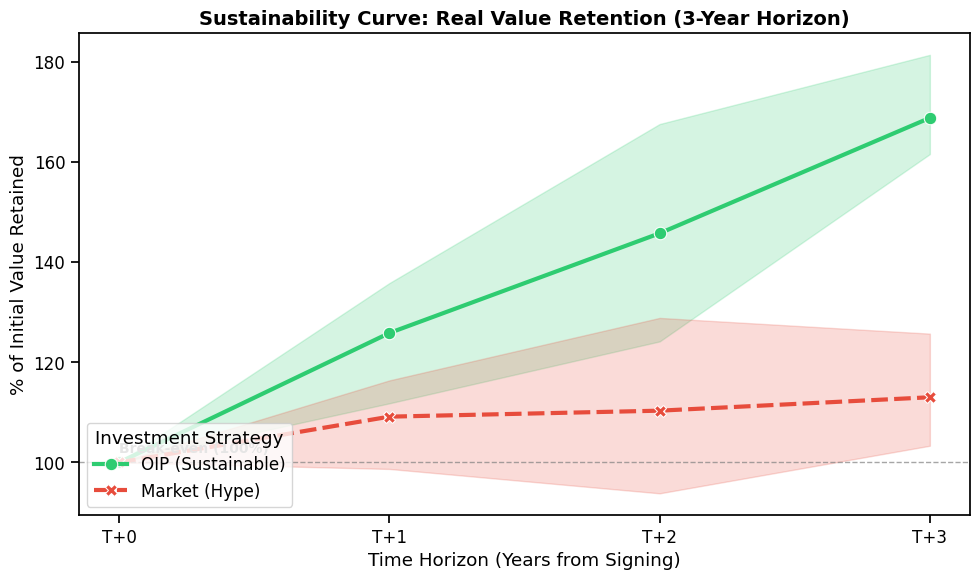

In [18]:
# ------------------------------------------------------------------------------
# A. SUSTAINABILITY CURVE (Long-Term Value Retention)
# ------------------------------------------------------------------------------
# Hypothesis: Traditional market strategies buy high (hype) and lose value (depreciation).
# OIP buys efficient (opportunity) and maintains/grows value over 3 years.

print(">>> Generating Visualizations...")

curve_data = []
# We analyze the "Top 1000" picks for each strategy to simulate a squad rotation
for year in [2016, 2017, 2018]:
    d = df_sim[df_sim['year'] == year]
    
    # Sort by score to get the best recommendations
    top_oip = d.sort_values('oip', ascending=False).head(1000)
    top_mv = d.sort_values('market_value', ascending=False).head(1000)
    
    for strategy, data in [('OIP (Sustainable)', top_oip), ('Market (Hype)', top_mv)]:
        # Baseline: Mean value at T=0 (Purchase moment)
        initial_avg = data['real_value_0y'].mean()
        if initial_avg == 0: continue
        
        # Calculate % Value Retention over time relative to T=0
        for t, col in enumerate(['real_value_0y', 'real_value_1y', 'real_value_2y', 'real_value_3y']):
            # Check if column exists (handling edge cases)
            if col in data.columns:
                retention = (data[col].mean() / initial_avg) * 100
                curve_data.append({
                    'Year': year, 
                    'Timeline': f'T+{t}', 
                    'Value_Retention': retention, 
                    'Strategy': strategy
                })

df_curve = pd.DataFrame(curve_data)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_curve, 
    x='Timeline', 
    y='Value_Retention', 
    hue='Strategy', 
    style='Strategy', 
    markers=True, 
    markersize=9, 
    linewidth=3, 
    palette=['#2ecc71', '#e74c3c'] # Green for OIP, Red for Market
)

plt.axhline(100, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.text(0, 102, 'Break-even (100%)', color='gray', fontsize=10, fontweight='bold')

plt.title('Sustainability Curve: Real Value Retention (3-Year Horizon)', fontsize=14, fontweight='bold')
plt.ylabel('% of Initial Value Retained')
plt.xlabel('Time Horizon (Years from Signing)')
plt.legend(title='Investment Strategy', loc='lower left')
plt.tight_layout()
plt.savefig('viz1_sustainability_curve.png', dpi=300)
plt.show()

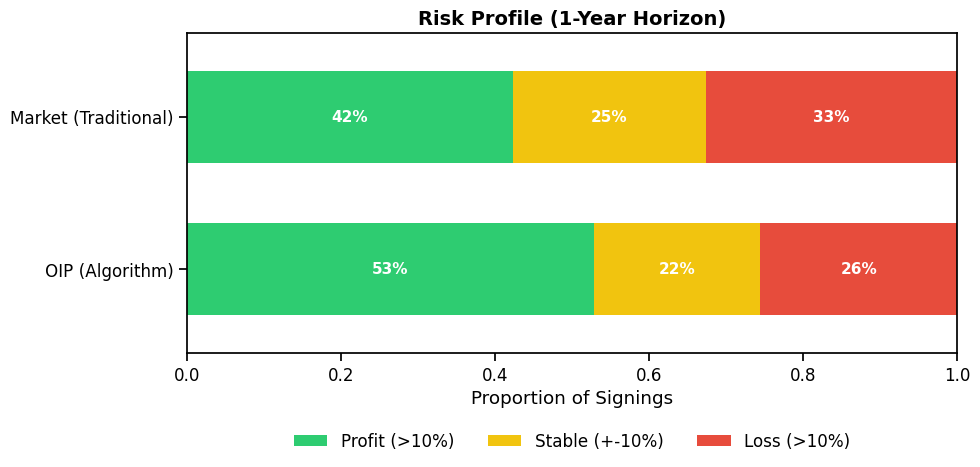

In [ ]:
# -------------------------------------------------------------------------
# B. RISK PROFILE (Outcome Distribution) - Filtrando top/bottom 5% ROI
# -------------------------------------------------------------------------

def categorize_outcome(roi):
    """Classifies the financial outcome of a signing after 2 years based on ROI."""
    if pd.isna(roi):
        return "Unknown"

    if roi < -0.10: 
        return "Loss (>10%)"      # Failed signing
    elif roi > 0.10: 
        return "Profit (>10%)"    # Successful signing
    else: 
        return "Stable (+-10%)"   # Value maintained


# Aggregate all years to get a robust distribution
all_oip = []
all_mv = []
for year in [2016, 2017, 2018]:
    d = df_sim[df_sim['year'] == year]
    all_oip.append(d.sort_values('oip', ascending=False).head(1000))
    all_mv.append(d.sort_values('market_value', ascending=False).head(1000))

df_risk_oip = pd.concat(all_oip, ignore_index=True).copy()
df_risk_mv = pd.concat(all_mv, ignore_index=True).copy()

# -----------------------------------------------------------
# Compute ROI once
# -----------------------------------------------------------
df_risk_oip['ROI'] = (df_risk_oip['real_value_1y'] - df_risk_oip['real_value_0y']) / df_risk_oip['real_value_0y']
df_risk_mv['ROI']  = (df_risk_mv['real_value_1y'] - df_risk_mv['real_value_0y']) / df_risk_mv['real_value_0y']

# -----------------------------------------------------------
# Remove top/bottom 5%
# -----------------------------------------------------------
low_oip, high_oip = df_risk_oip['ROI'].quantile([0.05, 0.95])
low_mv, high_mv   = df_risk_mv['ROI'].quantile([0.05, 0.95])

df_risk_oip = df_risk_oip[(df_risk_oip['ROI'] >= low_oip) & (df_risk_oip['ROI'] <= high_oip)]
df_risk_mv  = df_risk_mv[(df_risk_mv['ROI'] >= low_mv) & (df_risk_mv['ROI'] <= high_mv)]

# -----------------------------------------------------------
# Classify using filtered ROI directly
# -----------------------------------------------------------
df_risk_oip['Outcome'] = df_risk_oip['ROI'].apply(categorize_outcome)
df_risk_mv['Outcome']  = df_risk_mv['ROI'].apply(categorize_outcome)

# Filter Unknowns
valid_oip = df_risk_oip[df_risk_oip['Outcome'] != 'Unknown']
valid_mv  = df_risk_mv[df_risk_mv['Outcome'] != 'Unknown']

# Distribution table
risk_counts = pd.DataFrame({
    'OIP (Algorithm)': valid_oip['Outcome'].value_counts(normalize=True),
    'Market (Traditional)': valid_mv['Outcome'].value_counts(normalize=True)
}).T.fillna(0)

# Reorder columns
risk_cols = ['Profit (>10%)', 'Stable (+-10%)', 'Loss (>10%)']
risk_counts = risk_counts[[c for c in risk_cols if c in risk_counts.columns]]

# -----------------------------------------------------------
# Plot
# -----------------------------------------------------------
ax = risk_counts.plot(
    kind='barh', 
    stacked=True, 
    color=['#2ecc71', '#f1c40f', '#e74c3c'], 
    figsize=(10, 5),
    width=0.6
)

plt.title('Risk Profile (1-Year Horizon)', fontsize=14, fontweight='bold')
plt.xlabel('Proportion of Signings')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3, frameon=False)
plt.xlim(0, 1)

for c in ax.containers:
    labels = [f'{v.get_width()*100:.0f}%' if v.get_width() > 0.05 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('viz2_risk_profile_1_year.png', dpi=300)
plt.show()


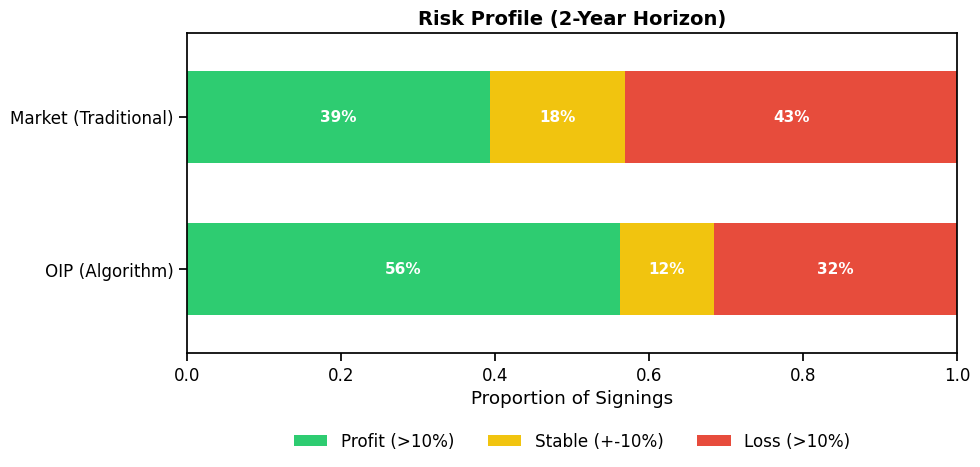

In [ ]:
# -------------------------------------------------------------------------
# B. RISK PROFILE (Outcome Distribution) - Filtrando top/bottom 5% ROI
# -------------------------------------------------------------------------

def categorize_outcome(roi):
    """Classifies the financial outcome of a signing after 2 years based on ROI."""
    if pd.isna(roi):
        return "Unknown"

    if roi < -0.10: 
        return "Loss (>10%)"      # Failed signing
    elif roi > 0.10: 
        return "Profit (>10%)"    # Successful signing
    else: 
        return "Stable (+-10%)"   # Value maintained


# Aggregate all years to get a robust distribution
all_oip = []
all_mv = []
for year in [2016, 2017, 2018]:
    d = df_sim[df_sim['year'] == year]
    all_oip.append(d.sort_values('oip', ascending=False).head(1000))
    all_mv.append(d.sort_values('market_value', ascending=False).head(1000))

df_risk_oip = pd.concat(all_oip, ignore_index=True).copy()
df_risk_mv = pd.concat(all_mv, ignore_index=True).copy()

# -----------------------------------------------------------
# Compute ROI once
# -----------------------------------------------------------
df_risk_oip['ROI'] = (df_risk_oip['real_value_2y'] - df_risk_oip['real_value_0y']) / df_risk_oip['real_value_0y']
df_risk_mv['ROI']  = (df_risk_mv['real_value_2y'] - df_risk_mv['real_value_0y']) / df_risk_mv['real_value_0y']

# -----------------------------------------------------------
# Remove top/bottom 5%
# -----------------------------------------------------------
low_oip, high_oip = df_risk_oip['ROI'].quantile([0.05, 0.95])
low_mv, high_mv   = df_risk_mv['ROI'].quantile([0.05, 0.95])

df_risk_oip = df_risk_oip[(df_risk_oip['ROI'] >= low_oip) & (df_risk_oip['ROI'] <= high_oip)]
df_risk_mv  = df_risk_mv[(df_risk_mv['ROI'] >= low_mv) & (df_risk_mv['ROI'] <= high_mv)]

# -----------------------------------------------------------
# Classify using filtered ROI directly
# -----------------------------------------------------------
df_risk_oip['Outcome'] = df_risk_oip['ROI'].apply(categorize_outcome)
df_risk_mv['Outcome']  = df_risk_mv['ROI'].apply(categorize_outcome)

# Filter Unknowns
valid_oip = df_risk_oip[df_risk_oip['Outcome'] != 'Unknown']
valid_mv  = df_risk_mv[df_risk_mv['Outcome'] != 'Unknown']

# Distribution table
risk_counts = pd.DataFrame({
    'OIP (Algorithm)': valid_oip['Outcome'].value_counts(normalize=True),
    'Market (Traditional)': valid_mv['Outcome'].value_counts(normalize=True)
}).T.fillna(0)

# Reorder columns
risk_cols = ['Profit (>10%)', 'Stable (+-10%)', 'Loss (>10%)']
risk_counts = risk_counts[[c for c in risk_cols if c in risk_counts.columns]]

# -----------------------------------------------------------
# Plot
# -----------------------------------------------------------
ax = risk_counts.plot(
    kind='barh', 
    stacked=True, 
    color=['#2ecc71', '#f1c40f', '#e74c3c'], 
    figsize=(10, 5),
    width=0.6
)

plt.title('Risk Profile (2-Year Horizon)', fontsize=14, fontweight='bold')
plt.xlabel('Proportion of Signings')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3, frameon=False)
plt.xlim(0, 1)

for c in ax.containers:
    labels = [f'{v.get_width()*100:.0f}%' if v.get_width() > 0.05 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('viz2_risk_profile_2_years.png', dpi=300)
plt.show()


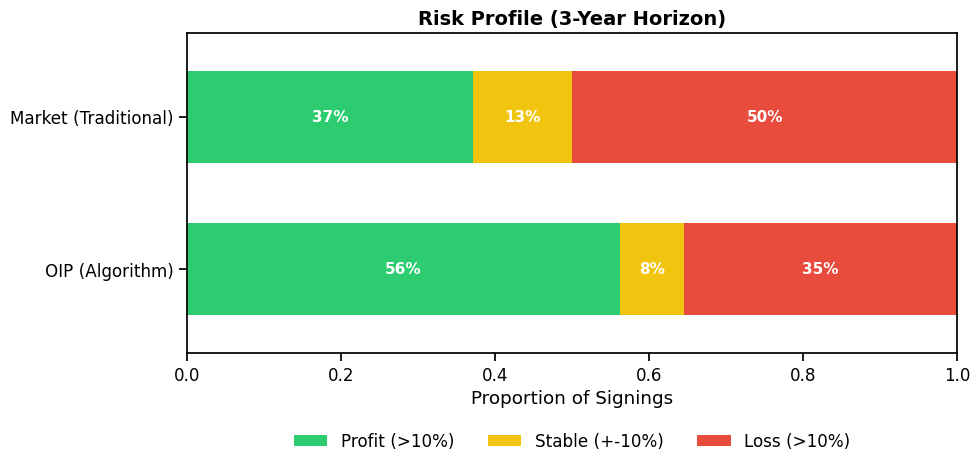

In [ ]:
# -------------------------------------------------------------------------
# B. RISK PROFILE (Outcome Distribution) - Filtrando top/bottom 5% ROI
# -------------------------------------------------------------------------

def categorize_outcome(roi):
    """Classifies the financial outcome of a signing after 2 years based on ROI."""
    if pd.isna(roi):
        return "Unknown"

    if roi < -0.10: 
        return "Loss (>10%)"      # Failed signing
    elif roi > 0.10: 
        return "Profit (>10%)"    # Successful signing
    else: 
        return "Stable (+-10%)"   # Value maintained


# Aggregate all years to get a robust distribution
all_oip = []
all_mv = []
for year in [2016, 2017, 2018]:
    d = df_sim[df_sim['year'] == year]
    all_oip.append(d.sort_values('oip', ascending=False).head(1000))
    all_mv.append(d.sort_values('market_value', ascending=False).head(1000))

df_risk_oip = pd.concat(all_oip, ignore_index=True).copy()
df_risk_mv = pd.concat(all_mv, ignore_index=True).copy()

# -----------------------------------------------------------
# Compute ROI once
# -----------------------------------------------------------
df_risk_oip['ROI'] = (df_risk_oip['real_value_3y'] - df_risk_oip['real_value_0y']) / df_risk_oip['real_value_0y']
df_risk_mv['ROI']  = (df_risk_mv['real_value_3y'] - df_risk_mv['real_value_0y']) / df_risk_mv['real_value_0y']

# -----------------------------------------------------------
# Remove top/bottom 5%
# -----------------------------------------------------------
low_oip, high_oip = df_risk_oip['ROI'].quantile([0.05, 0.95])
low_mv, high_mv   = df_risk_mv['ROI'].quantile([0.05, 0.95])

df_risk_oip = df_risk_oip[(df_risk_oip['ROI'] >= low_oip) & (df_risk_oip['ROI'] <= high_oip)]
df_risk_mv  = df_risk_mv[(df_risk_mv['ROI'] >= low_mv) & (df_risk_mv['ROI'] <= high_mv)]

# -----------------------------------------------------------
# Classify using filtered ROI directly
# -----------------------------------------------------------
df_risk_oip['Outcome'] = df_risk_oip['ROI'].apply(categorize_outcome)
df_risk_mv['Outcome']  = df_risk_mv['ROI'].apply(categorize_outcome)

# Filter Unknowns
valid_oip = df_risk_oip[df_risk_oip['Outcome'] != 'Unknown']
valid_mv  = df_risk_mv[df_risk_mv['Outcome'] != 'Unknown']

# Distribution table
risk_counts = pd.DataFrame({
    'OIP (Algorithm)': valid_oip['Outcome'].value_counts(normalize=True),
    'Market (Traditional)': valid_mv['Outcome'].value_counts(normalize=True)
}).T.fillna(0)

# Reorder columns
risk_cols = ['Profit (>10%)', 'Stable (+-10%)', 'Loss (>10%)']
risk_counts = risk_counts[[c for c in risk_cols if c in risk_counts.columns]]

# -----------------------------------------------------------
# Plot
# -----------------------------------------------------------
ax = risk_counts.plot(
    kind='barh', 
    stacked=True, 
    color=['#2ecc71', '#f1c40f', '#e74c3c'], 
    figsize=(10, 5),
    width=0.6
)

plt.title('Risk Profile (3-Year Horizon)', fontsize=14, fontweight='bold')
plt.xlabel('Proportion of Signings')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3, frameon=False)
plt.xlim(0, 1)

for c in ax.containers:
    labels = [f'{v.get_width()*100:.0f}%' if v.get_width() > 0.05 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('viz2_risk_profile_3_years.png', dpi=300)
plt.show()


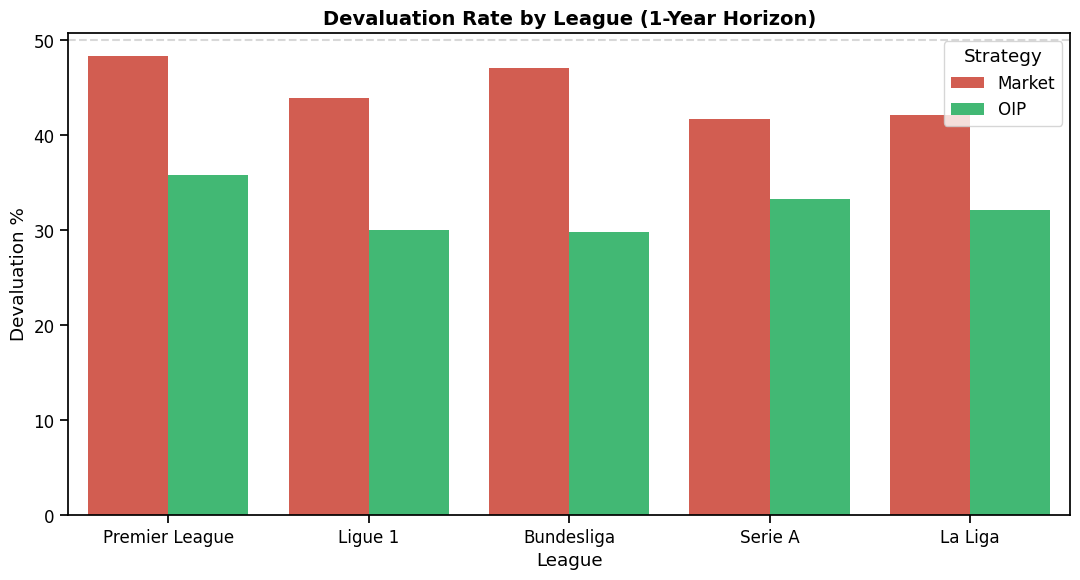

In [ ]:
# --- D. DEVALUATION BY LEAGUE ---
deval_data = []
for year in study_years:
    d = df_sim[df_sim['year'] == year]
    # Top 1000
    top_oip_g = d.sort_values('oip', ascending=False).head(1000).copy()
    top_mv_g = d.sort_values('market_value', ascending=False).head(1000).copy()
    top_oip_g['Strategy'] = 'OIP'
    top_mv_g['Strategy'] = 'Market'
    
    combined = pd.concat([top_oip_g, top_mv_g])
    combined['Devalued'] = combined['real_value_1y'] < combined['real_value_0y']
    
    summary = combined.groupby(['league_name', 'Strategy'])['Devalued'].agg(['mean', 'count']).reset_index()
    summary = summary[summary['count'] > 2]
    deval_data.append(summary)

df_deval_avg = (
    pd.concat(deval_data)
      .groupby(['league_name', 'Strategy'])['mean']
      .mean()
      .reset_index()
)

df_deval_avg['Devaluation_Pct'] = df_deval_avg['mean'] * 100

league_map = {
    'English Premier League': 'Premier League',
    'Spain Primera Division': 'La Liga',
    'German 1. Bundesliga': 'Bundesliga',
    'Italian Serie A': 'Serie A',
    'French Ligue 1': 'Ligue 1'
}

df_deval_avg['League'] = df_deval_avg['league_name'].map(league_map)

plt.figure(figsize=(11, 6))
sns.barplot(
    data=df_deval_avg,
    x='League',
    y='Devaluation_Pct',
    hue='Strategy',
    palette={'OIP': '#2ecc71', 'Market': '#e74c3c'}
)

plt.title('Devaluation Rate by League (1-Year Horizon)', fontsize=14, fontweight='bold')
plt.ylabel('Devaluation %')
plt.axhline(50, color='gray', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('viz3_leagues_1_year.png')

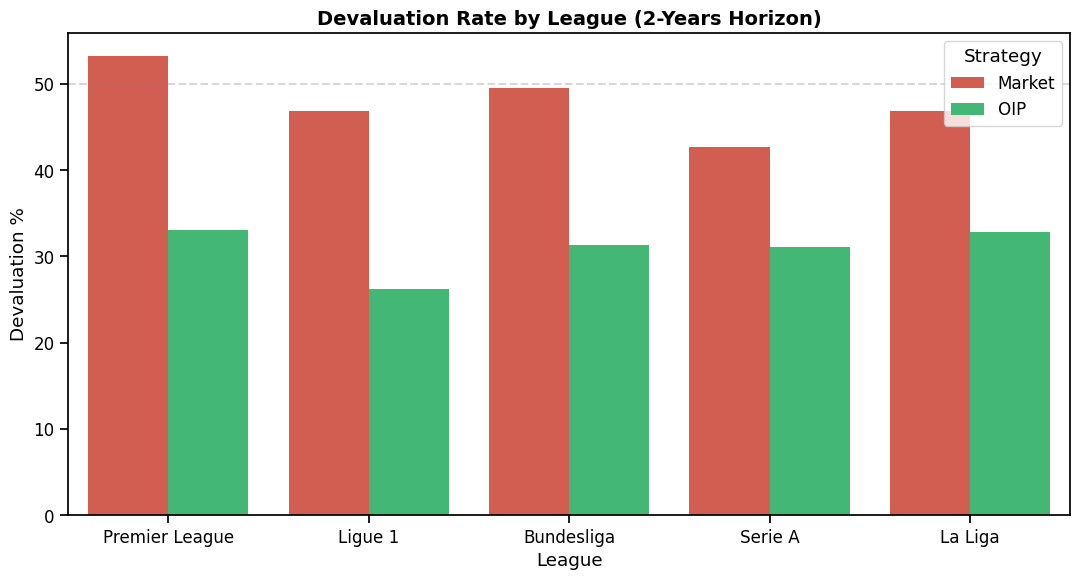

In [ ]:
# --- D. DEVALUATION BY LEAGUE ---
deval_data = []
for year in study_years:
    d = df_sim[df_sim['year'] == year]
    # Top 1000
    top_oip_g = d.sort_values('oip', ascending=False).head(1000).copy()
    top_mv_g = d.sort_values('market_value', ascending=False).head(1000).copy()
    top_oip_g['Strategy'] = 'OIP'
    top_mv_g['Strategy'] = 'Market'
    
    combined = pd.concat([top_oip_g, top_mv_g])
    combined['Devalued'] = combined['real_value_2y'] < combined['real_value_0y']
    
    summary = combined.groupby(['league_name', 'Strategy'])['Devalued'].agg(['mean', 'count']).reset_index()
    summary = summary[summary['count'] > 2]
    deval_data.append(summary)

df_deval_avg = (
    pd.concat(deval_data)
      .groupby(['league_name', 'Strategy'])['mean']
      .mean()
      .reset_index()
)

df_deval_avg['Devaluation_Pct'] = df_deval_avg['mean'] * 100

league_map = {
    'English Premier League': 'Premier League',
    'Spain Primera Division': 'La Liga',
    'German 1. Bundesliga': 'Bundesliga',
    'Italian Serie A': 'Serie A',
    'French Ligue 1': 'Ligue 1'
}

df_deval_avg['League'] = df_deval_avg['league_name'].map(league_map)

plt.figure(figsize=(11, 6))
sns.barplot(
    data=df_deval_avg,
    x='League',
    y='Devaluation_Pct',
    hue='Strategy',
    palette={'OIP': '#2ecc71', 'Market': '#e74c3c'}
)

plt.title('Devaluation Rate by League (2-Years Horizon)', fontsize=14, fontweight='bold')
plt.axhline(50, color='gray', linestyle='--', alpha=0.3)
plt.ylabel('Devaluation %')
plt.tight_layout()
plt.savefig('viz3_leagues_2_years.png')

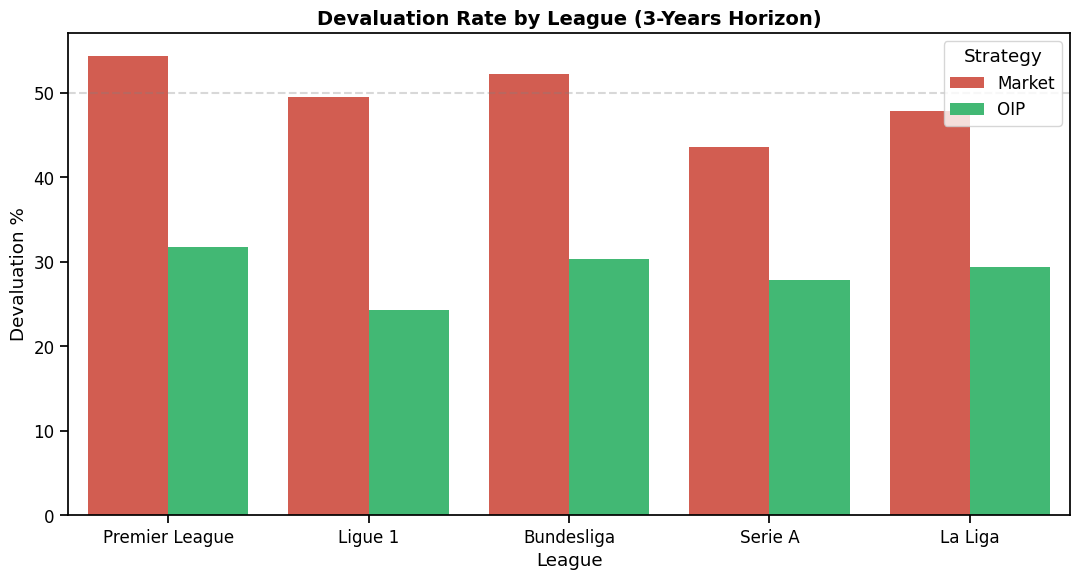

In [ ]:
# --- D. DEVALUATION BY LEAGUE ---
deval_data = []
for year in study_years:
    d = df_sim[df_sim['year'] == year]
    # Top 1000
    top_oip_g = d.sort_values('oip', ascending=False).head(1000).copy()
    top_mv_g = d.sort_values('market_value', ascending=False).head(1000).copy()
    top_oip_g['Strategy'] = 'OIP'
    top_mv_g['Strategy'] = 'Market'
    
    combined = pd.concat([top_oip_g, top_mv_g])
    combined['Devalued'] = combined['real_value_3y'] < combined['real_value_0y']
    
    summary = combined.groupby(['league_name', 'Strategy'])['Devalued'].agg(['mean', 'count']).reset_index()
    summary = summary[summary['count'] > 2]
    deval_data.append(summary)

df_deval_avg = (
    pd.concat(deval_data)
      .groupby(['league_name', 'Strategy'])['mean']
      .mean()
      .reset_index()
)

df_deval_avg['Devaluation_Pct'] = df_deval_avg['mean'] * 100

league_map = {
    'English Premier League': 'Premier League',
    'Spain Primera Division': 'La Liga',
    'German 1. Bundesliga': 'Bundesliga',
    'Italian Serie A': 'Serie A',
    'French Ligue 1': 'Ligue 1'
}

df_deval_avg['League'] = df_deval_avg['league_name'].map(league_map)

plt.figure(figsize=(11, 6))
sns.barplot(
    data=df_deval_avg,
    x='League',
    y='Devaluation_Pct',
    hue='Strategy',
    palette={'OIP': '#2ecc71', 'Market': '#e74c3c'}
)

plt.title('Devaluation Rate by League (3-Years Horizon)', fontsize=14, fontweight='bold')
plt.axhline(50, color='gray', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.ylabel('Devaluation %')
plt.savefig('viz3_leagues_3_years.png')